# scikit-learn: Training Neural Networks for Classification and Dimensionality Reduction

This notebook demonstrates example neural network setups for **image classification** and **dimensionality reduction** tasks using `scikit-learn`.

The examples serve as complement and comparison for exploring neural networks with the `edu.yaprnn` app.

Loading MNIST images from E:\edu.yaprnn\src\main\resources\digits.idx3-ubyte


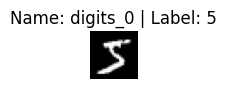

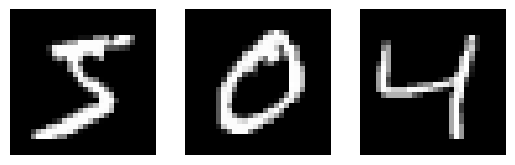

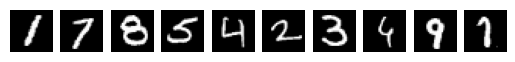

(36000, 784) (36000, 10) (36000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)
(48000, 784) (48000, 10) (48000,) (12000, 784) (12000, 10) (12000,)


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import mnist_utils

mnist_images, image_size, X, random_x_indices, random_feature_indices, y, labels = mnist_utils.from_mnist_images()

digits_train_32k_test_12k = train_test_split(X, y, labels, train_size=0.6, test_size=0.2, random_state=42)
digits_images_from_labels = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=42)
digits_input_reconstruction = train_test_split(X, y, labels, train_size=0.8, test_size=0.2, random_state=42)

mnist_utils.from_dataset(digits_train_32k_test_12k, explain=True)
mnist_utils.from_dataset(digits_images_from_labels, explain=True)
mnist_utils.from_dataset(digits_input_reconstruction, explain=True)

None

## Digits Classification

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 2 hidden layers:
    - Layer 1: 20 neurons
    - Layer 2: 15 neurons
  - Output layer: 10 neurons
  - Total parameters: `((784 + 1) * 20) + ((20 + 1) * 15) + ((15 + 1) * 10) = 16175` (Biases included)
- **Activation Function**:
  - scikit-learn supports only identity, logistic, tanh, relu. Latter is used as replacement for gelu.
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [2]:
from sklearn.neural_network import MLPClassifier


def count_parameters(_model):
    count_weights = np.sum([np.prod(w.shape) for w in _model.coefs_])
    count_bias = np.sum([np.prod(w.shape) for w in _model.intercepts_])
    print(f'Actual number of parameters: {count_weights + count_bias}')


input_size, output_size, X_train, y_train, X_test, y_test = mnist_utils.from_dataset(digits_train_32k_test_12k)

model = MLPClassifier(hidden_layer_sizes=(20, 15), activation='relu', solver='sgd', batch_size=31,
                      learning_rate_init=0.02, max_iter=50, momentum=0.2, nesterovs_momentum=True, alpha=0.001,
                      random_state=42)
model.fit(X_train, y_train)

count_parameters(model)

Actual number of parameters: 16175


E:\edu.yaprnn\notebooks\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [3]:
print(f'Accuracy on training set: {model.score(X_train, y_train)}')
print(f'Accuracy on test set: {model.score(X_test, y_test)}')

random_test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
predicted = model.predict_proba(X_test[random_test_indices])
print(np.argmax(predicted, axis=1))
predicted.round(2).astype('str')

Accuracy on training set: 0.9591388888888889
Accuracy on test set: 0.92175
[9 5 1 3 2]


array([['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '1.0'],
       ['0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'],
       ['0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0']], dtype='<U32')

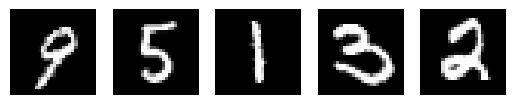

[9 5 1 3 2]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [4]:
mnist_utils.plot_images(X_test[random_test_indices], image_size=image_size, cmap='gray')
print(np.argmax(y_test[random_test_indices], axis=1))
y_test[random_test_indices]

## Dimensionality Reduction with an Autoencoder

This section demonstrates the use of two neural networks for dimensionality reduction. These networks rely on a bottleneck layer in their architecture to reduce the input data's dimensionality.

Instead of using predefined methods to extract the most relevant features, the networks are trained using backpropagation. This approach enables the model to automatically learn a transformation into a compressed feature space along with its inverse transformation to reconstruct the input data as accurately as possible.

### Shallow Autoencoder Network with 12 Neurons Bottleneck Layer

This model is configured as follows:

- **Architecture**:
  - Input layer: 784 neurons
  - 5 hidden layers:
    - Layer 1: 196 neurons
    - Layer 2: 49 neurons
    - Layer 3: 12 neurons
    - Layer 4: 49 neurons
    - Layer 5: 196 neurons
  - Output layer: 784 neurons
  - Total parameters: 328998 (Biases included)
- **Activation Function**: Rectified Linear Unit (ReLU)
- **Optimizer**: Stochastic Gradient Descent (SGD)
  - Learning rate: 0.02
  - Momentum: 0.2 with Nesterov term
  - L2-weight-decay: 0.001
- **Loss Function**: Mean Squared Error (MSE)

In [5]:
from sklearn.neural_network import MLPRegressor

_, _, X_train, _, X_test, _ = mnist_utils.from_dataset(digits_input_reconstruction)

model = MLPRegressor(hidden_layer_sizes=(196, 49, 12, 49, 196), activation='relu', solver='sgd', batch_size=31,
                     learning_rate_init=0.02, max_iter=100, momentum=0.2, nesterovs_momentum=True, alpha=0.001,
                     random_state=42)
model.fit(X_train, X_train)

count_parameters(model)

Actual number of parameters: 328998


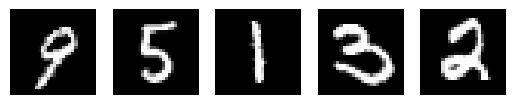

Score X_train: -2.2373898029327393
Score X_test: -19.725074768066406


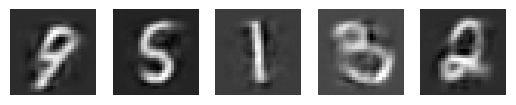

In [6]:
original = X_test[random_test_indices]
mnist_utils.plot_images(original, image_size=image_size, cmap='gray')

print(f'Score X_train: {model.score(X_train, X_train)}')
print(f'Score X_test: {model.score(X_test, X_test)}')
restored = model.predict(original)
mnist_utils.plot_images(restored, image_size=image_size, cmap='gray')